<center>
<h4></h4>
<h1><b>Negation </b></h1>
<h2>Deep Learning - Final Project</h2>
<h3>Buket Sak, <b>Ludmila Bajuk<b> , Kascha Kruschwitz</h3>
</center>


## CLASSIFYING NEGATION

For this project, we decided to work on negation since it is know to be a difficult aspect of natural language to process. Negation is very complex and it comes in different ways in language, in the form of lexical, (such as antonyms or opposites), semantic negation (contradiction and neative particles) clause negation (not- and no-negation), and many other forms. Exactly this, and the difference in syntactic structures when negation is used are some of the features that make negation difficult to implement, generate and classify for models.

To tackle this phenomena, we decided to use three different approaches. In order to have "benchmark" that could actually tell us that language models have difficulties when identifying, classifying and generating negation, we few-shoted GPT2 (EleutherAI/gpt-neo-1.3B) using examples taken manually from the dataset to evaluate its performance. After observing that clearly, at a first very simple approach language models struggle with negation, we decided to explore a bit more. First, we fine-tuned one already pre-trained model (bert-base-en-uncased) and adapt it to be a classifier that differentiates between negated and non-negated pairs of sentences. Secondly, we create BERT embeddings and fed to another model (BertBackbone) we created. Finally, we created a third model with different layers and other parameters, to manage this phenomena in diverse approaches. 

We imported all the requirements for the code to run. We have also uploaded a requirements.txt file just in case.


In [2]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  

import numpy as np
import tensorflow as tf
import keras
import keras_nlp
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import torch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import display
import pandas as pd
import random
from statistics import mean
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import time
import transformers
from transformers import AutoTokenizer, GPTNeoForCausalLM

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


2024-08-12 08:15:46.969835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 08:15:46.969948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 08:15:47.092587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The dataset that we are using, Cannot, its a compilation of annotated, negation-oriented text pairs. It contains 77,376 samples of negated pairs and non-negated (paraphrased) pairs. The datasert is formated in .tsv and it contains 3 columns. The first one includes the premises, meaning a sentece (which can be negates or not). The second column, has the hypothesis of the premise and this can be eith an equivalent(paraphrased) or non-negated sentence or the negated version of the original sentences. Then, the third column if the label (0 or 1) that indicates whether the pair of senteces are non-negated or negated, respectively. 

The dataset was built by merging 5 differents datasets:
- Not another Negation Benchmark: The NaN-NLI Test Suite for Sub-clausal Negation (see datasets/nan-nli).

- GLUE Diagnostic Dataset (see datasets/glue-diagnostic).

- Automated Fact-Checking of Claims from Wikipedia (see datasets/wikifactcheck-english).

- From Group to Individual Labels Using Deep Features (see datasets/sentiment-labelled-sentences). In this case, the negated sentences were obtained by using the Python module negate.

- It Is Not Easy To Detect Paraphrases: Analysing Semantic Similarity With Antonyms and Negation Using the New SemAntoNeg Benchmark (see datasets/antonym-substitution).

The combination of datasets contained a variety of complex negation forms, such as negative particles, antonyms, syntactic negated structures, double negation, not-negation, no-negation, etc. 


In [3]:
# loaded in hulk server as well

dataset = pd.read_csv('/kaggle/input/cannot/cannot_dataset_v1.1.tsv', sep='\t')

### GPU settings

Code from Andrea, taken to load the models quicker using a GPU.

In [4]:
# check if GPU
if torch.cuda.is_available(): #check if GPU is available
    device = torch.device("cuda:1") #set device, we need this later to push our model and the data to the GPU to perform computations
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
Device name: Tesla T4


In [5]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Mon Aug 12 08:18:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# select a specific GPU
selected_gpu = 0  # Change this to 0, 1, or 2 depending on which GPU you want to use

# Check if the specified GPU is available
if torch.cuda.is_available() and selected_gpu < torch.cuda.device_count():
    torch.cuda.set_device(selected_gpu)  # Set the selected GPU as the current device
    device = torch.device(f"cuda:{selected_gpu}")
    print(f'Using GPU {selected_gpu}.')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i} name:', torch.cuda.get_device_name(i))
    print('Current GPU:', torch.cuda.current_device())

else:
    print('No specified GPU available, using the CPU instead.')
    device = torch.device("cpu")

Using GPU 0.
There are 2 GPU(s) available.
GPU 0 name: Tesla T4
GPU 1 name: Tesla T4
Current GPU: 0


### Exploring the data

Our dataset was rather clean since it had been pre-processed before. However, we had to work on it so that it could become the adequate input for our models. More so, our choosen task did not involve any type stemming or stopword removal, since in this classification task we were interested in more semantic aspects.

Label 1: 39989 samples, which is 51.68% of the dataset.
Label 0: 37387 samples, which is 48.32% of the dataset.


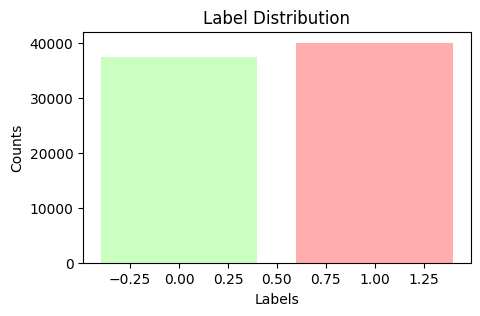

In [23]:
# We counted the labels to see if they are evenly distributed and it is easier to work with.

lables = dataset["label"]

label_count = {}
for i in lables:
    if i in label_count:
        label_count[i] += 1
    else:
        label_count[i] = 1

# We plotted them for better visualization
total_samples = sum(label_count.values())

for label, count in label_count.items():
    percentage = (count / total_samples) * 100
    print(f"Label {label}: {count} samples, which is {percentage:.2f}% of the dataset.")

labels = list(label_count.keys())
counts = list(label_count.values())
plt.figure(figsize=(5, 3))

plt.bar(labels, counts, color=['#ffadad', '#caffbf'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.show()

We shuffled the data rows (this code inspired on the TBBT Toturial) using random seeds, so that the test and traing data are ordered randomly. 

In [24]:
# We established a random seed
random_seed = 42
random.seed(random_seed)

# we shuffled the rows of the df but kept original index of the sentence pairs.
dataset = dataset.sample(frac=1, random_state=random_seed)

# We put the shuffled row in a DataFrame
df = pd.DataFrame(dataset)

print(f"{df.shape[0]} rows x {df.shape[1]} columns")
styled_df = dataset.head(10).style.set_properties(**{
    'text-align': 'left',
    'font-size': '12pt',
    'background-color': 'white'
})
styled_df

77376 rows x 3 columns


,premise,hypothesis,label
32439,"Peek graduated from Oregon High School in Oregon, Illinois.",Peek attended Oregon High School in Illinois.,0
73705,"Accordingly, they were unable to use phenomenology in the development of categorial grammar.","Accordingly, they employed phenomenology in the development of categorial grammar.",1
54863,A class action lawsuit is currently filed against Aurora Loan Services.,There is a class action lawsuit against Aurora Loan Services.,0
62360,Their chow mein is so good!,The chow mein is very good.,0
23682,"The MATs (Multiple Access Transponder) components, MAT-1 and MAT-2, utilize Hughes Aircraft CDP1802CD microprocessors.",The Hughes Aircraft CDP1802CD microprocessors are used in the MATs.,0
14338,Other British musicians included Bainton.,Other British musicians included Edgar Bainton.,0
76575,Haploview can do association studies.,"Haploview can also perform association studies, choosing tag SNPs.",0
31168,"Also, the fries aren't without a doubt the worst fries I've ever had.","Also, the fries are without a doubt the worst fries I've ever had.",1
47771,The eastern portion of the county lies within the Blue Ridge Mountains.,The eastern portion of the county lies outside the Blue Ridge Mountains.,1
68903,The substantive distinction between law and equity has not changed.,"However, the substantive distinction between law and equity has retained its old vitality.",0


After reordering the data, we randomly selected a few sentences to use later for the model's quality evaluation and further analysis. 

In [30]:
# We selected 10 random antonymic and not-negated sentence pairs and 10 non-negated ones.
# The numbers are the indeces of different pairs of senteces.
antonym_row_names = [50487, 41715, 32427, 48323, 27068]
negation_row_names = [57658, 37518, 14465, 42008, 560]
paraphrased_row_names = [6543, 51922, 16802, 66953, 24641, 14896, 20770, 70327, 34157, 64309]

# This function takes one of the lists above, iterates over the indices, 
# and returns their corresponding index in the dataframe.
def get_df_index(row_names):
  index_list = []
  for i in row_names:
    index_list.append(dataset.index.get_loc(dataset.loc[i].name))
  return index_list

antonym_index = get_df_index(antonym_row_names)
negation_index = get_df_index(negation_row_names)
paraphrased_index = get_df_index(paraphrased_row_names)

print("Antonym Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(antonym_row_names, antonym_index):
    print(f"{original:<15} {new:<15}")

print("\nNegation Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(negation_row_names, negation_index):
    print(f"{original:<15} {new:<15}")

print("\nParaphrased Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(paraphrased_row_names, paraphrased_index):
    print(f"{original:<15} {new:<15}")

Antonym Indices:
Original        Shuffled       
50487           43790          
41715           45169          
32427           22999          
48323           47219          
27068           65592          

Negation Indices:
Original        Shuffled       
57658           72246          
37518           18988          
14465           6395           
42008           65701          
560             70849          

Paraphrased Indices:
Original        Shuffled       
6543            52227          
51922           62089          
16802           42129          
66953           12637          
24641           51031          
14896           70166          
20770           62622          
70327           51589          
34157           68365          
64309           36405          


Next, we prepared a small subdata that we will later use to make predictions with the model to see how it performed. We collected the features and true labels from the base data for the corresponding antonymic, negated and paraphrased pair of sentences to then evaluate the model. 

In [31]:
# We combined the list of indices and the rows
pred_indices = antonym_index + negation_index + paraphrased_index
pred_rows = antonym_row_names + negation_row_names + paraphrased_row_names

# We created a dictionary with the tensors 
pred_features = {
    "token_ids": tf.stack([preprocessed_data['token_ids'][i] for i in pred_indices]),
    "segment_ids": tf.stack([preprocessed_data['segment_ids'][i] for i in pred_indices]),
    "padding_mask": tf.stack([preprocessed_data['padding_mask'][i] for i in pred_indices]),
}

# We extracted the true labels from the columns of the dataset and convert ir to a list. 
pred_labels = list(dataset.loc[[i for i in pred_rows], "label"])


print(f"{'Shuffled Index':<15} {'Original Row Name':<20} {'Label':<5}")
for shuffled_index, original_row, label in zip(pred_indices, pred_rows, pred_labels):
    print(f"{shuffled_index:<15} {original_row:<20} {label:<5}")
    

Shuffled Index  Original Row Name    Label
43790           50487                1    
45169           41715                1    
22999           32427                1    
47219           48323                1    
65592           27068                1    
72246           57658                1    
18988           37518                1    
6395            14465                1    
65701           42008                1    
70849           560                  1    
52227           6543                 0    
62089           51922                0    
42129           16802                0    
12637           66953                0    
51031           24641                0    
70166           14896                0    
62622           20770                0    
51589           70327                0    
68365           34157                0    
36405           64309                0    


# FEW SHOT GPT2

As a "benchmark", we decided to few shot GPT2 (EleutherAI/gpt-neo-1.3B) which is a tranformer pre-trained model so that the by providing a few examples or templates of the prompt you will give the model in the future and a task description, it gains understanding of the task it has to do and generates answers.

In [32]:
# Load the pre-trained GPT-2 model and tokenizer
model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = GPTNeoForCausalLM.from_pretrained(model_name)

In [33]:
# We manually collected some sample sentence pairs to use as templates and examples for the model to
# use for the prediction of the negation or non-negation label. We extracted 2 pairs samplea from 
# each dataset within the cannot dataset.
classification_examples = """
Classify the hypothesis as a negated (1) or non-negated (0) version of the premise. Examples:
Premise: This is a bad idea.
Hypothesis: This is not a good idea.
Label: 1
###
Premise: It's not healthy.
Hypothesis: It's unhealthy.
Label: 0
###
Premise: No one has a set of principles to live by.
Hypothesis: Everyone has a set of principles to live by.
Label: 1
###
Premise: The cat was sitting on the mat.
Hypothesis: The cat sat on the mat.
Label: 0
###
Premise:  I saw nothing at all.
Hypothesis: I didn't see anything.
Label: 0
###
Premise: Both do good jobs and are quite amusing.
Hypothesis: Both do good jobs and aren't quite amusing.
Label: 1
###
Premise: Griffon has been banned from being publicly traded since 1961.
Hypothesis: Griffon has been publicly traded since 1961.
Label: 1
###
Input: The plant will probably die if it hasn't had enough time to regenerate.
Hypothesis: If the plant has not had time to sufficiently regenerate it will probably perish.
Label: 0
###
Input: It's not uneasy to explain.
Hypothesis: It's not easy to explain.
Label: 1
###
Input: After retiring in 1954, Yee worked for a long time with Harrington.
Hypothesis: After retiring in 1954, Yee worked with Harrington nearly every day.
Label: 0
"""


In [34]:
# This function make the model generate a label for the input pair of senteces you feed it.
def classify_neg(classification_examples, premise, hypothesis):
    # We define the type of prompy that the model will receive.
    prompt = f"{classification_examples}\n\n{premise}\n\n{hypothesis}\n\n Label:"

    # Then, tokenize the prompt.
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # The model generated the label given the examples that it was given before.
    output = model.generate(
        input_ids,
        max_length=len(input_ids[0]) + 50,  # Increase length to allow for longer outputs.
        num_return_sequences=1,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    # We decoded the generated label given we need special tokens.
    generated_classification = tokenizer.decode(output[0], skip_special_tokens=True)

    # We extracted the classification label.
    start_idx = generated_classification.find("Label:") + len("Label:")
    end_idx = generated_classification.find("###", start_idx)
    if end_idx == -1:
        end_idx = None
    classification_result = generated_classification[start_idx:end_idx].strip()

    return classification_result

In [35]:
# We gave the model as input the senteces that we randomly selected a few cells above
# since those are the one we then, will use to evaluate out other models.
premises = list(dataset.loc[[i for i in pred_rows], "premise"])
hypothesees = list(dataset.loc[[i for i in pred_rows], "hypothesis"])
print(premises)
print(hypothesees)

# We make GPT generate the predicted labels.
gpt_pred = []
for prem, hyp in zip(premises, hypothesees):
    answer = classify_neg(classification_examples, prem, hyp)
    gpt_pred.append(answer)

print(gpt_pred)


["That's a good idea.", "There's something that's not right.", 'He would die before this work was complete.', 'It has a high gable roof and marble end chimneys.', 'She often uses deliberately unrealistic characters in her work such as simplified archetypes.', "She didn't leave.", 'Its foundations are not Gravel Point, Charlevoix Limestone, Petoskey, and Whiskey Creek.', "Looks good in the picture, but this case wasn't a huge disappointment!!", "It doesn't work great with a car charger, especially if you cannot plug in two adapters at the same time.", 'External corrosion was not suspected at all.', 'They are followed by small oval fruit.', "No, it's the same thing.", "I'm not a good talker either.", 'Grisham was close to winning the popular vote.', 'Their menu is reasonably priced.', 'Shetty was elected to the Karnataka Legislative Assembly in 1967 from the Puttur constituency.', 'HMAC_DRBG also has a machine-verified security proof.', 'The contract to buy Solel Solar Systems was signed

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


As we can see, in this first look at how language models handle negation, the model captures everything as negated which clearly show that models need a lot more of specification, and work in order to more precisely classify sentences into negated or not.

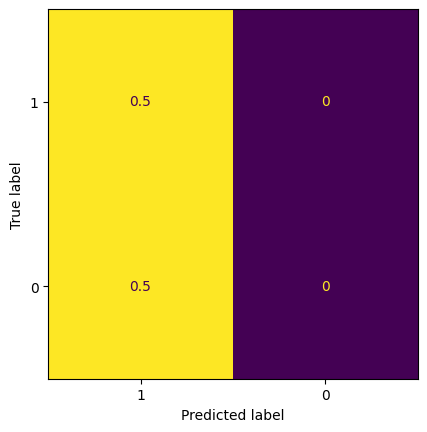

In [36]:
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(pred_labels, [int(i) for i in gpt_pred], normalize='pred', labels=[1,0] )

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
result_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["1", "0"])

# display matrix
result_display.plot(colorbar=False)
plt.show()

## Pre-processing
Now, we start to pre-process the input that we will feed into the models.

In [38]:
# With this function we checked how long the inputs are. We first checked for each premise, hypothesis
# label separatedly and then, in the next cells we compare them altogether for better understanding of
# the dataset.

def max_len(column):
  lent = list()
  for i in dataset[column]:
    lent.append(len(str(i).split(" ")))
  return (min(lent), max(lent), mean(lent))

# We created a table with the maximum, minimum and mean length of each premise, hypothesis and label.
premise_min, premise_max, premise_mean = max_len("premise")
hypothesis_min, hypothesis_max, hypothesis_mean = max_len("hypothesis")
label_min, label_max, label_mean = max_len("label")

print(f"{'':<12} {'Min Length':<12} {'Max Length':<12} {'Mean Length':<12}")

print(f"{'Premise':<12} {premise_min:<12} {premise_max:<12} {premise_mean:<12.2f}")
print(f"{'Hypothesis':<12} {hypothesis_min:<12} {hypothesis_max:<12} {hypothesis_mean:<12.2f}")
print(f"{'Label':<12} {label_min:<12} {label_max:<12} {label_mean:<12.2f}")


             Min Length   Max Length   Mean Length 
Premise      1            58           10.69       
Hypothesis   1            58           10.69       
Label        1            1            1.00        


Analysis of the 'premise' column:
Minimum length of sequences: 1
Maximum length of sequences: 58
Average length of sequences: 10.69
Number of sequences < 16 tokens: 72317
Percentage of sequences < 16 tokens: 93.46%
Number of sequences >= 16 tokens: 5059
Percentage of sequences >= 16 tokens: 6.54%


Analysis of the 'hypothesis' column:
Minimum length of sequences: 1
Maximum length of sequences: 58
Average length of sequences: 10.69
Number of sequences < 16 tokens: 72317
Percentage of sequences < 16 tokens: 93.46%
Number of sequences >= 16 tokens: 5059
Percentage of sequences >= 16 tokens: 6.54%




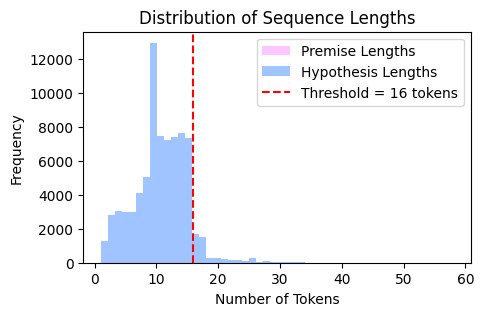

In [39]:
# We analized the 'premise' and 'hypothesis' columns. Length of column, of sequences (also between them).
def analyze_sequence_lengths(dataset, column, threshold=16):
    min_len, max_len_val, avg_len = max_len(column)

    sequence_lengths = [len(str(i).split(" ")) for i in dataset[column]]

    # We count how many sequences are longer than or equal to the threshold
    longer_sequences = [length for length in sequence_lengths if length >= threshold]
    percentage_longer_sequences = (len(longer_sequences) / len(sequence_lengths)) * 100

    # We counted how many sequences are shorter than  to the threshold
    shorter_sequences = [length for length in sequence_lengths if length < threshold]
    percentage_shorter_sequences = (len(shorter_sequences) / len(sequence_lengths)) * 100

    
    print(f"Analysis of the '{column}' column:")
    print(f"Minimum length of sequences: {min_len}")
    print(f"Maximum length of sequences: {max_len_val}")
    print(f"Average length of sequences: {avg_len:.2f}")
    print(f"Number of sequences < {threshold} tokens: {len(shorter_sequences)}")
    print(f"Percentage of sequences < {threshold} tokens: {percentage_shorter_sequences:.2f}%")
    print(f"Number of sequences >= {threshold} tokens: {len(longer_sequences)}")
    print(f"Percentage of sequences >= {threshold} tokens: {percentage_longer_sequences:.2f}%")
    print("\n")

    return sequence_lengths, len(longer_sequences), percentage_longer_sequences


premise_lengths, premise_longer_count, premise_longer_percentage = analyze_sequence_lengths(dataset, "premise")
hypothesis_lengths, hypothesis_longer_count, hypothesis_longer_percentage = analyze_sequence_lengths(dataset, "hypothesis")

# We plotted the distributions
plt.figure(figsize=(5, 3))

plt.hist(premise_lengths, bins=50, alpha=1, label='Premise Lengths', color="#ffc6ff")
plt.hist(hypothesis_lengths, bins=50, alpha=1, label='Hypothesis Lengths', color = "#a0c4ff")

plt.axvline(x=16, color='red', linestyle='--', label='Threshold = 16 tokens')

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Tokenizing, padding and truncating

Using keras-nlp we started to prepare the data to input the first BERT model by tokenizing and padding the sequences. With the BERT tokenizer we converted the raw text into numerical representations so that BERT can process it correctly. Then, we used the preprocessor to include the special tokens to the sequences and we set the maximum length (32 tokens) the sequences had to be in order to truncate them to that length with round_robin. We used truncation strategy because it works well with inputs of multiple sequences like our that is a pair of sentences. 

In [40]:
# We did the tokenizing and padding for the sequences.
tokenizer = keras_nlp.models.BertTokenizer.from_preset(
    "bert_base_en_uncased")

# The max input for BERT is 512 so we make sure the input fits the model.
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased", sequence_length=32, truncate="round_robin")

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle 

We extracted the relevant inputs for the model using TensorFlow, meaning the premise (sentence) and the hypothesis (negated or non-negated version of the first sentence). Then, we applied tokenization, padding, inseted the special tokens, and segmented using the BERT preprocessor. 

When this step was done, we got the token IDs, padding masks and IDs of the segments since we need them from the BERT model. Finally, we decoded the token IDs to verify we tokenized correctly.

In [41]:
# We prepared the input forthe masking task, the sentence order task and the token's ids.
# We created a constant with all the premises and hypothesis.
first = tf.constant([dataset["premise"][i] for i in range(len(dataset))])
second = tf.constant([dataset["hypothesis"][i] for i in range(len(dataset))])
preprocessed_data = preprocessor((first, second)) 

# Tensors
token_ids = preprocessed_data['token_ids'] 
padding_mask = preprocessed_data['padding_mask'] 
segment_ids = preprocessed_data['segment_ids']  

# Here we checked how the padding and special token insertion works.
decoded_text = tokenizer.detokenize((preprocessed_data["token_ids"])[:8])
print("Decoded Text (First 8 Samples):")
for i, text in enumerate(decoded_text.numpy()):
    print(f"Sample {i+1}: {text.decode('utf-8')}\n")

Decoded Text (First 8 Samples):
Sample 1: [CLS] the joint typhoon warning center ( jtwc ) also issued warnings in an [SEP] the joint typhoon warning center ( jtwc ) only issued warnings in [SEP]

Sample 2: [CLS] commercial dnp is used as an antiseptic and as a non - [SEP] commercial dnp is unable to be utilized as an antiseptic or [SEP]

Sample 3: [CLS] spinal locks and cervical locks are allowed and mandatory in ibjjf brazilian [SEP] spinal locks and cervical locks are forbidden in ibjjf brazilian ji [SEP]

Sample 4: [CLS] dredgers excavate the sediment using mechanical or hydraulic methods or a combination of both [SEP] the dredgers use either mechanical or hydraulic methods . [SEP]

Sample 5: [CLS] in 2014 , nextgen earns klas top performance honors for ambula [SEP] in 2014 , nextgen fails to achieve klas top performance honors for [SEP]

Sample 6: [CLS] on june 22 , 2009 , the sec also filed civil fraud charges . [SEP] on june 22 , 2009 , the sec kept itself from filing civil fraud

In [42]:
# Here we simply extracted the labels
labels = list(dataset["label"])
print(labels[100:200])

# We converted them into binary format using unique values.
# We got an array of unique values and an array of indices.
labels_01 = np.unique(np.array(labels), return_inverse=True)[1]
# Into binary with keras.
labels_01  = to_categorical(labels_01)
# We converted the labels into numpy array.
labels_02 = np.asarray(labels)

[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]


### Data Splitting

On this step, we splited the data. We divide it into training and testing data. Also, we splited the features, which will be the input data and the labels which will be the output data. 

In [43]:
# 85% of the data will be used for training. 
training_samples = (len(labels) * 85)//100

# Training data 
x_train_token_ids = preprocessed_data['token_ids'][:training_samples]
x_train_segment_ids = preprocessed_data["segment_ids"][:training_samples]
x_train_padding_mask = preprocessed_data["padding_mask"][:training_samples]

y_train_01 = labels_01[:training_samples]
y_train_02 = labels_02[:training_samples]

# Test data
x_test_token_ids = preprocessed_data['token_ids'][training_samples:]
x_test_segment_ids = preprocessed_data["segment_ids"][training_samples:]
x_test_padding_mask = preprocessed_data["padding_mask"][training_samples:]

y_test_01 = labels_01[training_samples:]
y_test_02 = labels_02[training_samples:]

# We made sure the split was correct.
print("Shape of token IDs:", x_train_token_ids.shape)
print("Shape of label tensor:", y_train_01.shape)
print("Shape of label tensor:", y_train_02.shape)

# We created dictionaries combining all features.
x_train_features = {
    "token_ids": x_train_token_ids,
    "segment_ids": x_train_segment_ids,
    "padding_mask": x_train_padding_mask,
}

x_test_features = {
     "token_ids": x_test_token_ids,
    "segment_ids": x_test_segment_ids,
    "padding_mask": x_test_padding_mask,
}

features = {
    "token_ids": preprocessed_data['token_ids'],
    "segment_ids": preprocessed_data["segment_ids"],
    "padding_mask": preprocessed_data["padding_mask"],
}

Shape of token IDs: (65769, 32)
Shape of label tensor: (65769, 2)
Shape of label tensor: (65769,)


# **MODEL 1**

This model was inspired on Semantic Similarity with KerasNLP (https://keras.io/examples/nlp/semantic_similarity_with_keras_nlp/), in which a pre-trained model was used for the semantic similarity task that determines the similarity between two sentences when it comes to meaning. What we did was to adapt this idea to our own classifying negation task. 

We used a BERT classifier pre-trained model (bert_base_en_uncased) to create a model and retrained it for our own purposes, but without using its preprocessor since we costum process the data ourselves. For this model, we needed to have 2 classes because we are doing binary classification between negated and non-negated, so that has to be specified.  

In [44]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased", preprocessor = None,
    num_classes=2, load_weights=True,  trainable=True
    ) 

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'met

In [45]:
# We compile the model by specifying the loss function with Binary Crossentropy since the model would predict one class 
# or another and the loss is calculated. We also set the Adam optimizer that updates the model's weights and we set the 
# a relatively high learning rate, because after a few tries, this learning rate seem to work better than 0.001. More so, 
# we set accuracy as the evaluation metric.
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=['accuracy']
)

# Now we trained the BERT classifier. We fed the training data and the labels. Then, we specified the model to go through
# the training data 5 times, since we have 5 epochs and we set 64 samples the model has to go through. Also, we set a 20% 
# of data to be used for validation to evaluate its performance and not overfit.
history_01 = classifier.fit(
    x_train_features, y_train_01,
    epochs=5, batch_size=64, validation_split=0.2, verbose = 1
)

Epoch 1/5


I0000 00:00:1723455419.899675     320 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723455419.977610     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4927 - loss: 0.8001

W0000 00:00:1723455792.151180     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723455796.621187     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 513s 485ms/step - accuracy: 0.4927 - loss: 0.8001 - val_accuracy: 0.5154 - val_loss: 1.2447
Epoch 2/5


W0000 00:00:1723455819.128266     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 303s 368ms/step - accuracy: 0.4969 - loss: 0.7786 - val_accuracy: 0.5154 - val_loss: 1.3003
Epoch 3/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 302s 367ms/step - accuracy: 0.4984 - loss: 0.7772 - val_accuracy: 0.5154 - val_loss: 1.1821
Epoch 4/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 302s 367ms/step - accuracy: 0.4977 - loss: 0.7749 - val_accuracy: 0.5154 - val_loss: 1.2361
Epoch 5/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 301s 366ms/step - accuracy: 0.4994 - loss: 0.7768 - val_accuracy: 0.5154 - val_loss: 1.2003


After this step, we evaluate the model with the test data we separated to assess in an unbaised way since it is data the model has not seen before. The model here makes predictions and compare them to the actual labels to calculate the loss and accuracy. In this case, the can see that the model does not do very well as the loss value is much higher than the accuracy. This evaluation showed that the model is not classifying negation properly. 

In [46]:
test_ev_01 = classifier.evaluate(x_test_features, y_test_01)

  2/363 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.5469 - loss: 1.1286

W0000 00:00:1723457378.997178     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.5203 - loss: 1.1891


W0000 00:00:1723457400.324427     319 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Now, we plotted the model's accuracy, loss, evaluation to visualize the model performance, and we can observe by looking at the plots that the model does not learn almost at all. 

In [47]:
# This function plots the accuracy, loss and evaluation and it will be reused in every model.
def plot_training_history(history, test_metrics):

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(accuracy) + 1)

    # We plotted training and validation accuracy.
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
    plt.plot(max(epochs_range), test_metrics[1], 'go', label='Test acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # We plotted training and validation loss.
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r', label='Training loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
    plt.plot(max(epochs_range), test_metrics[0], 'go', label='Test acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


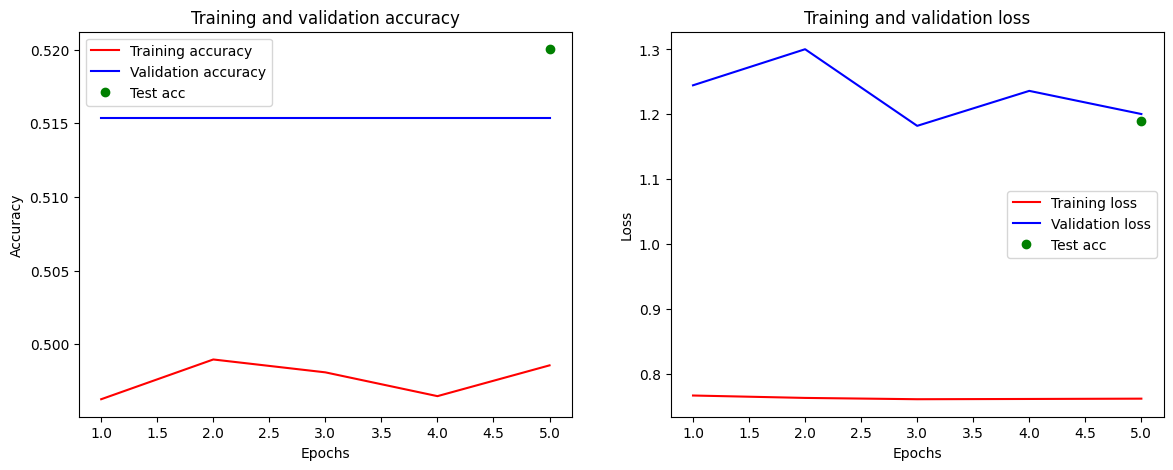

In [48]:
plot_training_history(history_01, test_ev_01)

### Model 1 predictions

We used the softmax function to interpret all the models' predictions. This function exponentiates each item of the input and divides each of them by the sum of all the exponentiated values that resulted in the distribution over the classes. Once we got the probabilities (that sum up to 1), we can see the confidence the model has on each class. Then, from the predicted classes we took highest probability to get the final predicted class label.

In [49]:
# We converted the list of labels into an array to be compatible with the function. 
pred_predictions = classifier.predict(pred_features)
pred_labels_array = np.array(pred_labels)
print(pred_labels_array)

# We converted the outputs of the classifier into probabilities that sum up to 1
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0) 

# We got the class predictions with maximum probabilities
predictions1 = softmax(pred_predictions)
predicted_classes1 = np.argmax(predictions1, axis=1)
print("Predicted labels:", predicted_classes1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


W0000 00:00:1723457411.570809     319 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Classification Report

Here, we evaluated the model's performance at classificating the pair senteces a negated or non-negated by calculating some key metrics such as accuracy and the f1 score. The reason we need to calculate the f1 score is because accuracy (the times the model predicted correctly) sometimes can be misleading because depending on our data or input fed to the model. Therefore, the f1 score gaves us a harmonic mean between precision and recall. In our case, the classification report with precision, recall and F1 score is very important because our dataset is imbalanced and small. This code was inspired from Andrea's code in the TBBT tutorial. 

In [50]:
def evaluate_classification(pred_labels, predicted_classes):

    # We calculated accuracy
    accuracy = accuracy_score(pred_labels, predicted_classes)

    # We calculated the macro-F1 score
    macro_f1 = f1_score(pred_labels, predicted_classes, average='macro')

    # We generated a classification report
    detailed_report = classification_report(pred_labels, predicted_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-F1 Score: {macro_f1:.4f}")
    print("Detailed Classification Report:")
    print(detailed_report)

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'classification_report': detailed_report
    }

As we can see below, we can tell that the model has a significant issue predicting negated sentences correctly (class 1) and it is very baised towards class 0. The average precision for predicted any of the class is also significantly low (0.25) which indicates that the model is not reliable at all and totally imbalanced, since it seems to be slightly working for only 1 class ad completely failing for the other one. 

In [51]:
evaluate_classification(pred_labels, predicted_classes1) 

Accuracy: 0.5000
Macro-F1 Score: 0.3333
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.5,
 'macro_f1': 0.3333333333333333,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.50      1.00      0.67        10\n           1       0.00      0.00      0.00        10\n\n    accuracy                           0.50        20\n   macro avg       0.25      0.50      0.33        20\nweighted avg       0.25      0.50      0.33        20\n'}

### Confusion Matrix Model 1

We used sklearn.metrics to compute a confusion matrix and further evaluate the accuracy of the model. We used the actual labels and the predicted labels by the classifier and normalize so that every column will sum up to 1. This, showed us which predicted classes were correct or incorrect. 

As we can see from the graph, the model 1 is baised towards predicting that the pairs of sentences are non-negated, however, the model is still not good.More so, there are no true positives for negated sentence pairs which indicates that it failed to predict them. 


[[0.  0.5]
 [0.  0.5]]


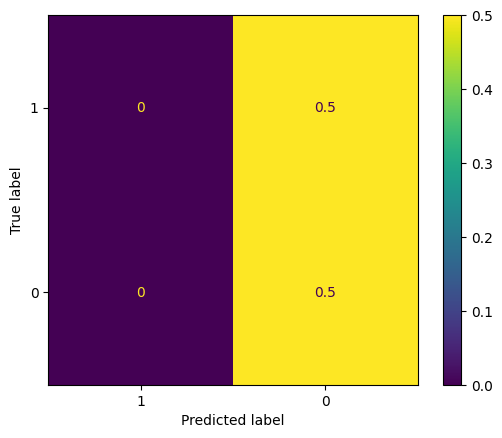

In [52]:
# We created a confusion matrix and normalized it over the predicted columns.
result1 = confusion_matrix(pred_labels_array, predicted_classes1, normalize='pred', labels=[1,0] )
print(result1)

# We visualized the confusion matrix with sklearn metrics.
result_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = result1, display_labels = ["1", "0"])

result_display1.plot()
plt.show()

# **Model 2**

As in for model one, we used bert_base_en_uncased but this time we did not retrain it, but we used it a feature extractor that will take the data we splitted and the embedding we created (dense vector representations) as inout and perform a classification task again. For model 2 , we created embeddings (being inspired by Andrea's fine-tuning in the TBBT tutorial) fed them into a pretrained model BERT Backbone (which is an embedder model)and use also, keras-nlp. 

In [53]:
# We had to use again the GPU because sometimes the code crashed so had to insist on maintaining the GPU usage. 
with tf.device('/device:GPU:0'):  
    embedder = keras_nlp.models.BertBackbone.from_preset(
        "bert_base_en_uncased",  load_weights=True, preprocessor=None, trainable=False
    )

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...


### Embeddings



In [54]:
# We created two types of embeddings for the next 2 models. 
# We have 2 types of outputs for the embedding layer. First, we got the sequences output which one embedding per word in a sequence. And then,
# the other output is the pooled embeddings which is a combination of the sequence embedding because is the embedding for the entire sequence.

# We used time only to see how long it took to generate the embedidng and see how much time everything would take.
start_time = time.time()

batch_size = 32
# The sequence embedding output is used as input for model 3, since it has LSTM layer and we input one word at the time. Token embedding.
seq_embeddings = []
# The pooled embedding output is used as input for model 2, since it has a dense layer and it does not take into account the word order. Sequence embedding(2 sentences).
pool_embeddings = []
for i in range(0, len(features["token_ids"]), batch_size):
    with tf.device('/device:GPU:0'): 
        # We created a dictionary containing all the features for the tasks.
        batch_features = {
            "token_ids": features["token_ids"][i: i + batch_size],
            "segment_ids": features["segment_ids"][i: i + batch_size],
            "padding_mask": features["padding_mask"][i: i + batch_size],
        }
        # We generated the embeddings for the batch of features.
        batch_embeddings = embedder(batch_features)
        seq_embeddings.extend(batch_embeddings['sequence_output'])
        pool_embeddings.extend(batch_embeddings['pooled_output'])


# We recorded the end time.
end_time = time.time()

# We calculate the elapsed time.
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Elapsed time: 533.74 seconds


In [55]:
# For visualization.
print("Number of Sequence Embeddings:", len(seq_embeddings))
print("Length of y_train_02:", len(y_train_02))
print("Number of Token IDs in Features:", len(features["token_ids"]))
print("\nSample of Token IDs (first 2):")
print(features["token_ids"][:2])
print("\nSample Data (first 2 sequences):")
print(seq_embeddings[:2])

Number of Sequence Embeddings: 77376
Length of y_train_02: 65769
Number of Token IDs in Features: 77376

Sample of Token IDs (first 2):
tf.Tensor(
[[  101  1996  4101 15393  5432  2415  1006  1046  2102 16526  1007  2036
   3843 16234  1999  2019   102  1996  4101 15393  5432  2415  1006  1046
   2102 16526  1007  2069  3843 16234  1999   102]
 [  101  3293  1040 16275  2003  2109  2004  2019  3424  3366 20746  1998
   2004  1037  2512  1011   102  3293  1040 16275  2003  4039  2000  2022
  12550  2004  2019  3424  3366 20746  2030   102]], shape=(2, 32), dtype=int32)

Sample Data (first 2 sequences):
[<tf.Tensor: shape=(32, 768), dtype=float32, numpy=
array([[-0.9500362 , -0.02559358, -0.42308766, ..., -0.8528032 ,
         0.09129428,  0.07362685],
       [-0.06119687, -0.11673031, -0.4369478 , ...,  0.09962112,
         1.2962011 ,  0.13774018],
       [ 0.16016704, -0.19487922,  0.3218239 , ..., -0.12377342,
         0.19195   , -0.5271513 ],
       ...,
       [-0.01281314,  0.408

### Data splitting and reshaping

In [57]:
# Since we did not use the preprocessor we had to prepare the data, and split and select it for the different models.
# We reshaped the pool embedding into a 2 dimensional tensor to feed it to the model 2.
reshaped_pool_embeddings = tf.reshape(pool_embeddings, shape=(-1, 768))
# We set the pool embedding as trainig and test data.
x_train_02 = reshaped_pool_embeddings[:training_samples]
x_test_02 = reshaped_pool_embeddings[training_samples:]

# We set the sequence embeddings as training and test data.
x_train_03 = seq_embeddings[:training_samples]
x_test_03 = seq_embeddings[training_samples:]

# We set the maximum number of sequence embeddings to be processed without running out of GPU memory. 
train_03_len = 40000

# We stacked the embedding into a tensor. We converted the embedding into a 3 dimension tensor. The 
# 1st dim is the batch size, the 2nd is the sequence length and the 3rd is the pool embedding size.
with tf.device('/device:GPU:1'): 
    x_train_03 = tf.stack(x_train_03[:train_03_len])
    x_test_03 = tf.stack(x_test_03)

print(x_train_03.get_shape())

# We did the same thing for the sequence embedding for model 3.
y_train_03 = y_train_02[:train_03_len]
y_test_03 = y_test_02

# Then, we prepared the data for the embedder's predictions 
x_pred_02 = tf.gather(reshaped_pool_embeddings,
                indices=pred_indices)

x_pred_03 = [seq_embeddings[x] for x in pred_indices]

x_pred_03 = tf.stack(x_pred_03)

(40000, 32, 768)


### Set up of Model 2 for sequence embeddings


In [58]:
# We set up the sequential model with all its dense layers 
model_02 = Sequential(name='Model_02')
model_02.add(layers.Dense(256, activation='relu', input_shape=(768,)))
model_02.add(layers.Dense(256, activation='relu'))
model_02.add(layers.Dense(128, activation='relu'))
model_02.add(layers.Dense(64, activation='relu'))
model_02.add(layers.Dense(16, activation='relu'))
model_02.add(layers.Dense(1, activation='sigmoid'))

model_02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_02.summary()

# We used the Adam optimizer again, but this time we changed the batch size to 32 and the validation data to only 10%.
# We also increased the number of epoch to 50. 
history_02 = model_02.fit(x_train_02, y_train_02,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,865 (1.16 MB)

 Trainable params: 304,865 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
  79/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4828 - loss: 0.7157

W0000 00:00:1723458504.504094     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5083 - loss: 0.6965

W0000 00:00:1723458509.512261     321 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723458509.991721     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5083 - loss: 0.6965 - val_accuracy: 0.5194 - val_loss: 0.6925
Epoch 2/50
  80/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4894 - loss: 0.6969

W0000 00:00:1723458510.644593     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5133 - loss: 0.6932 - val_accuracy: 0.5194 - val_loss: 0.6925
Epoch 3/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5169 - loss: 0.6926 - val_accuracy: 0.5194 - val_loss: 0.6928
Epoch 4/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5154 - loss: 0.6928 - val_accuracy: 0.5194 - val_loss: 0.6924
Epoch 5/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5144 - loss: 0.6929 - val_accuracy: 0.5194 - val_loss: 0.6925
Epoch 6/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5122 - loss: 0.6929 - val_accuracy: 0.5195 - val_loss: 0.6924
Epoch 7/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5163 - loss: 0.6927 - val_accuracy: 0.5194 - val_loss: 0.6925
Epoch 8/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5191 - loss: 0.6925 - val_accuracy: 0.5192 - val_loss: 0.6926
Epoch 9/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5163 - loss: 0.6927 - val_accurac

In [59]:
# We evaluated model 2.
test_ev_02 = model_02.evaluate(x_test_02, y_test_02)

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5200 - loss: 0.7000


W0000 00:00:1723458794.908792     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


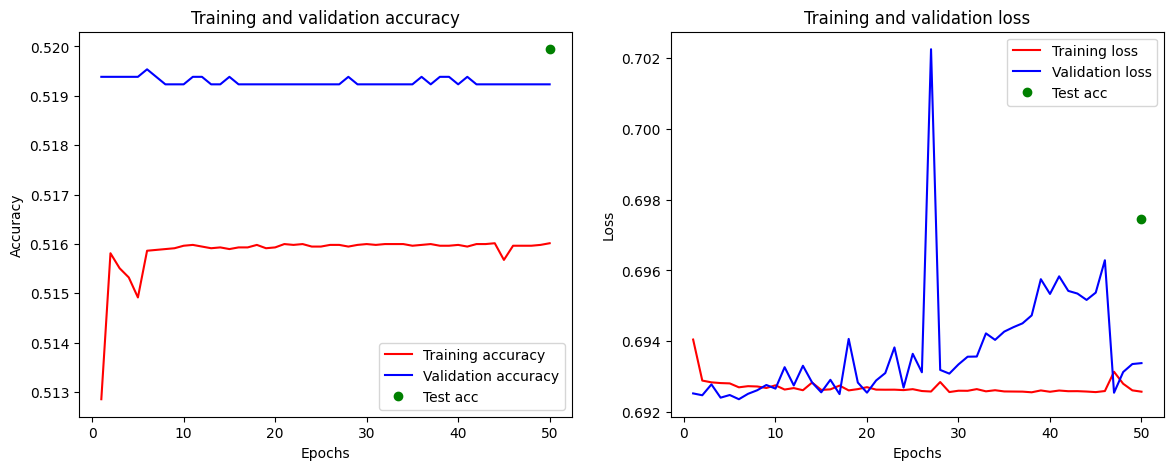

In [60]:
# We plotted the accuracy, loss and evaluation. 
plot_training_history(history_02, test_ev_02)

In [61]:
# We converted the list of labels into an array to be compatible with the function. 
# We did the same as in model 1, but now for model 2. 
pred_predictions2 = model_02.predict(x_pred_02)
pred_labels_array = np.array(pred_labels)
print(pred_labels_array)
print(pred_predictions)

predicted_classes2 = [1 if prob[0] >= 0.5 else 0 for prob in pred_predictions2]
predicted_classes2_array = np.array(predicted_classes2)

print(predicted_classes2_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[[-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.275087 ]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]
 [-2.2745764  2.2750874]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


W0000 00:00:1723458804.314508     319 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Classification Report Model 2

Once again, for the evaluation we can observe that the model 2 does not perform well either. However, this time the model is baised towards the other class (1), meaning it performs better (50%) with negated pairs of sentences.

The other scores remain the same as in model one, which indicated that the 50% accuracy in this binary classification task is totally misleading again. The accuracy might suggest that it performs half well, but the precision, recall and f1 score helped us see that the model does not distinguish between the classed properly. 

In [62]:
evaluate_classification(pred_labels, predicted_classes2) 

Accuracy: 0.5000
Macro-F1 Score: 0.3333
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.5,
 'macro_f1': 0.3333333333333333,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        10\n           1       0.50      1.00      0.67        10\n\n    accuracy                           0.50        20\n   macro avg       0.25      0.50      0.33        20\nweighted avg       0.25      0.50      0.33        20\n'}

### Confusion Matrix Model 2

In the graph for model 2  we can see the opposition against model 1 that I mentioned above, since this model 2 is baised towards predicting that the pairs of sentences are negated.

[[0.5 0. ]
 [0.5 0. ]]


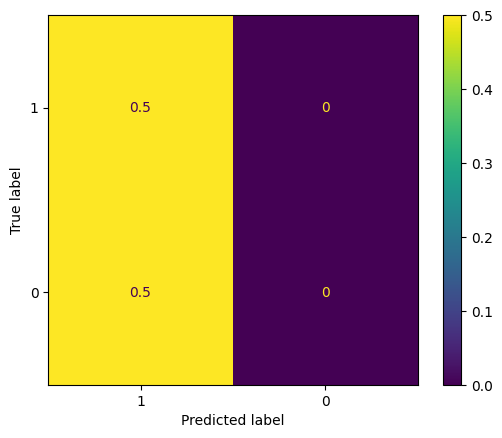

In [63]:
# We create a confusion matrix for model 2
result2 = confusion_matrix(pred_labels_array, predicted_classes2 , normalize='pred', labels=[1,0] )
print(result2)

result_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = result2, display_labels = ["1", "0"])

result_display2.plot()
plt.show()

# Model 3

For model 3, in which we fed the token embedding we changed a few parameter to see if the performance was enhanced. Therefore, we included an LSTM layer which could be efficient for learning in sequences (one vector at a time) and reduced the other dense layers. Thistime we reduced the number of epoch to 20 and increased the batch size to 64 but mantained the validation data at 10%. 

In [64]:
model_03 = Sequential(name='Model_03')

model_03.add(layers.LSTM(128, input_shape=(32, 768)))
model_03.add(layers.Dense(32, activation='relu'))
model_03.add(layers.Dense(1, activation='sigmoid'))

model_03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_03.summary()

history_03 = model_03.fit(x_train_03, y_train_03,
                            epochs=20,
                            batch_size=64,
                            validation_split=0.1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Model_03"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,425 (1.77 MB)

 Trainable params: 463,425 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5045 - loss: 0.6954 - val_accuracy: 0.5073 - val_loss: 0.6943
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5197 - loss: 0.6921 - val_accuracy: 0.5040 - val_loss: 0.6936
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5189 - loss: 0.6921 - val_accuracy: 0.4992 - val_loss: 0.6942
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5347 - loss: 0.6892 - val_accuracy: 0.5027 - val_loss: 0.6961
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5598 - loss: 0.6829 - val_accuracy: 0.4908 - val_loss: 0.7054
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5817 - loss: 0.6699 - val_accuracy: 0.5030 - val_loss: 0.7117
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6356 - loss: 0.6369 - val_accuracy: 0.5100 - val_loss: 0.7414
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6881 - loss: 0.5786 - val_accuracy: 0.

In [65]:
# We evaluated model 3
test_ev_03 = model_03.evaluate(x_test_03, y_test_03)

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4959 - loss: 2.2780


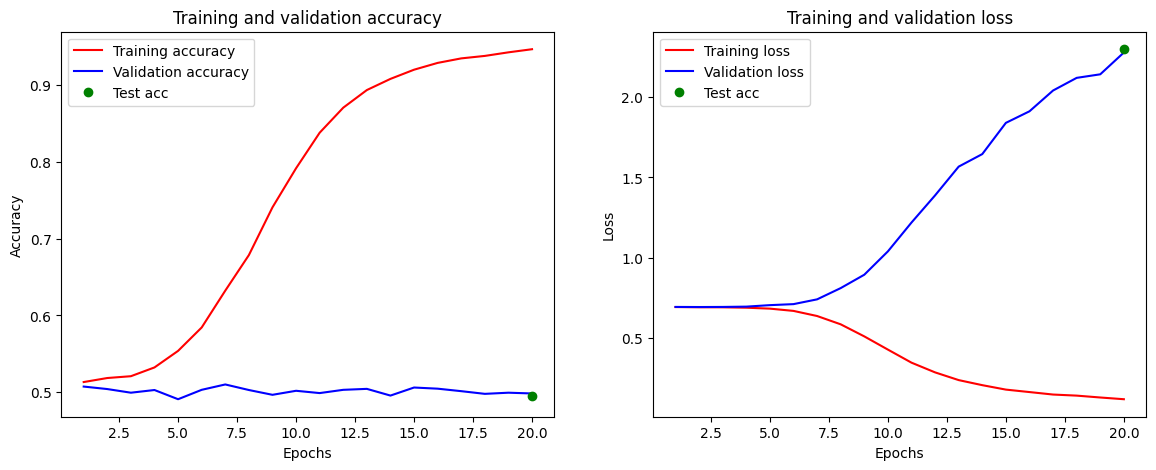

In [66]:
# We plotted the accuracy, loss and evaluation and this time we can actually see that the model does learn much better than in the other models.
plot_training_history(history_03, test_ev_03)

In [67]:
# We got the predictions for model 3.
pred_predictions3 = model_03.predict(x_pred_03)
print(pred_labels_array)

predicted_classes3 = [1 if prob[0] >= 0.5 else 0 for prob in pred_predictions3]
predicted_classes3_array = np.array(predicted_classes3)
print(predicted_classes3_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0]


### Classification Report Model 3

This model performed different from the other 2 models. In this case, the accuracy increased reaching a 75%, which is better than the other two model but it is still not very optimal. The macro f1 score, says that the model can accurately classify 74% of the samples, which is still not the highest but still better than in the other models and a bit more balanced.

Similarly to model 2, this model is more precise when it has to classify negated sentenced with an accuracy of 78% for the class 1. However, the recall  in class 0 (80%) is pretty high indicating that the model is better at classifying non-negates sentences.

Then, if we take into account the macro average we could say that the model's performance is fairly better, but still baised towards class 1.


In [68]:
evaluate_classification(pred_labels, predicted_classes3)

Accuracy: 0.7500
Macro-F1 Score: 0.7494
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



{'accuracy': 0.75,
 'macro_f1': 0.7493734335839599,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.73      0.80      0.76        10\n           1       0.78      0.70      0.74        10\n\n    accuracy                           0.75        20\n   macro avg       0.75      0.75      0.75        20\nweighted avg       0.75      0.75      0.75        20\n'}

### Confusion matrix

The model predicted negates sentences pairs to actual negated ones in a rather acceptable way with 78% of true positives. More so, the missclassification was of a %22 means that the error rate is not that high but could be improved. In the confusion matrix, it shows that the model is precise  at predicting non-negated pairs of sentences as well, but in the classification report we can see that the model is slightly baised towards negated sentences since the recall and f1 scores shows us the real evaluation not only taking into account precision.

[[0.77777778 0.27272727]
 [0.22222222 0.72727273]]


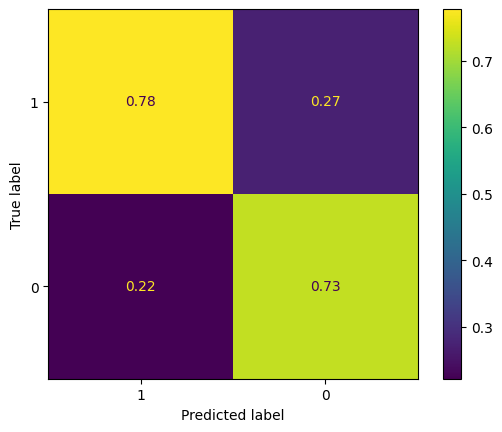

In [69]:

#Create confusion matrix and normalizes it over predicted (columns)
result3 = confusion_matrix(pred_labels_array, predicted_classes3 , normalize='pred', labels=[1,0] )
print(result3)
# visualize confusion matrix with sklearn metrics
# define matrix and create labels
result_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix = result3, display_labels = ["1", "0"])

# display matrix
result_display3.plot()
plt.show()

## Final evaluation of all models

<Figure size 640x480 with 0 Axes>

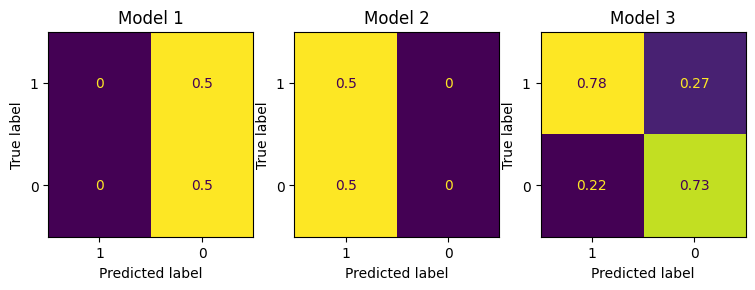

In [74]:
# We plotted all confusion matrices for better visualization and comparison.
plt.clf()

fig = plt.figure(figsize=(9, 4)) 

sp1 = plt.subplot(1, 3, 1)
result_display1.plot(ax=sp1) 
plt.gca().images[-1].colorbar.remove()
plt.title("Model 1")


sp2 = plt.subplot(1, 3, 2)
result_display2.plot(ax=sp2)
plt.gca().images[-1].colorbar.remove()
plt.title("Model 2")


sp3 = plt.subplot(1, 3, 3)
result_display3.plot(ax=sp3)
plt.gca().images[-1].colorbar.remove()
plt.title("Model 3")

plt.show()

All in all, model 1 needs a lot of improvement, particularly in recognizing negated senteces; model 2 depicts great imbalance when differentiating the classed, as well but, in this case, the model performs poorly specially with non-negated; and finally, model 3 performs much better than the other two but having very similar results as model 2 being a bit more accurate when predicting negated sentence pairs.

In [75]:

table_df = {
    " ": [i for i in range(20)],
    "Premise": dataset.loc[[i for i in pred_rows], "premise"],
    "Hypothesis": dataset.loc[[i for i in pred_rows], "hypothesis"],
    "Actual Labels": dataset.loc[[i for i in pred_rows], "label"],
    "Predicted Labels Model 1": predicted_classes1,
    "Predicted Labels Model 2": predicted_classes2,
    "Predicted Labels Model 3": predicted_classes3,
    "Predicted Labels GPT": gpt_pred
}

df = pd.DataFrame(table_df).reset_index(drop=True)

def highlighter(cell_value):
    if cell_value < 5:
        return 'background-color: plum'
    elif cell_value < 10:
        return 'background-color: lightblue'
    elif cell_value < 20:
        return 'background-color: lightgreen'
    else:
        return ''

pretty_df = df.style.applymap(highlighter, subset=[" "]).hide(axis="index")
display(pretty_df)

/tmp/ipykernel_34/398772560.py:24: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pretty_df = df.style.applymap(highlighter, subset=[" "]).hide(axis="index")


,Premise,Hypothesis,Actual Labels,Predicted Labels Model 1,Predicted Labels Model 2,Predicted Labels Model 3,Predicted Labels GPT
0,That's a good idea.,That's an evil idea.,1,0,1,1,1
1,There's something that's not right.,There's something that's not incorrect.,1,0,1,0,1
2,He would die before this work was complete.,He would die after this work was complete.,1,0,1,1,1
3,It has a high gable roof and marble end chimneys.,It has a low gable roof and brick end chimneys.,1,0,1,0,1
4,She often uses deliberately unrealistic characters in her work such as simplified archetypes.,She never make use of deliberately unrealistic characters in her work such as simplified archetypes.,1,0,1,1,1
5,She didn't leave.,She left.,1,0,1,1,1
6,"Its foundations are not Gravel Point, Charlevoix Limestone, Petoskey, and Whiskey Creek.","Its formations are Gravel Point, Charlevoix Limestone, Petoskey, and Whiskey Creek.",1,0,1,1,1
7,"Looks good in the picture, but this case wasn't a huge disappointment!!","Looks good in the picture, but this case was a huge disappointment!!",1,0,1,1,1
8,"It doesn't work great with a car charger, especially if you cannot plug in two adapters at the same time.","It works great with a car charger, especially if you cannot plug in two adapters at the same time.",1,0,1,0,1
9,External corrosion was not suspected at all.,External corrosion was suspected.,1,0,1,1,1


To conclude, the overall performance of model 1 and 2 was very poorly with an accuracy of around 50% and a macro f1-score of 33%, which denotes that the models are working at a random choice level for this being a binary task of 50/50 chance of getting one of the labels right. The major failure point of the models we re being strongly baised towards one class only and this could probably because the dataset is not properly balanced and that it was a rather small dataset that contained very complex words and ways of negation. More so, another way to make specifically model 2 work better could have been to try and use another type of embeddings that could help the model leanring more efficiently.

Then, model 3 works much better with an accuracy of 75% than the other two and we believe mainly this is because it was fed tokens embeddings. It still fails to achieve very high precision and recall in negated and non-negated classes because it does not fully differentiate between them. This could be the data's fault since it has, for example, double negated sentences, which sometimes are even difficult to understand for humans; or antonyms that could be classifies in different ways. Another issue might have been the preprocessing of the input but then again a rather small dataset makes everything a bit more difficult.

Negation is a very complex language phenomena and there is so much more further analysis, investigation and work to do for language models to work properly with it. 


## Sources

 Anschütz, M., Lozano, D. M., & Groh, G. (2023). This is not correct! Negation-aware Evaluation of Language Generation Systems. arXiv. Available at: https://arxiv.org/abs/2307.13989

Black, S., Gao, L., Wang, P., Leahy, C., & Biderman, S. (2021). GPT-Neo: Large Scale Autoregressive Language Modeling with Mesh-Tensorflow (Version 1.0) [Software]. Zenodo. https://doi.org/10.5281/zenodo.5297715

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. CoRR, abs/1810.04805. Available at: http://arxiv.org/abs/1810.04805

Truong, A., Mathew, P., Wang, Y., & Kumar, S. (2022). Not another Negation Benchmark: The NaN-NLI Test Suite for Sub-clausal Negation. Presented at AACL-IJCNLP 2022.
